## Importing the Libraries

In [1]:
## Import libraries

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm

import cv2
import json
%matplotlib inline 
IS_LOCAL = False
import os
from imgaug import augmenters as iaa
from tqdm import tqdm
from tqdm import notebook
import glob
from keras.layers import ZeroPadding2D, Cropping2D

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' ## disable debugging logs of tensorflow

cwd = os.getcwd()
PATH=cwd + "\input\\rsna-pneumonia-detection-challenge"
model_directory = cwd + "\model"

## print the input directories
    
print(os.listdir(PATH))

C:\Users\DoH\Anaconda3\envs\gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['GCP Credits Request Link - RSNA.txt', 'stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_test_images', 'stage_2_train_images', 'stage_2_train_labels.csv']


Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
### IMPORTING MASK RCNN AND COCO WEIGHTS

PATH=cwd + "\Mask_RCNN"
print(PATH)
import sys
from keras.callbacks import Callback
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

D:\greatlakes\CAPSTONE\Mask_RCNN


## Importing Data from JSON File

In [3]:
## Import JSON File
json_path=cwd+"\\train_class_dataframe.json"
print(json_path)
train_class_dataframe=pd.read_json(path_or_buf=json_path,orient ='table')

D:\greatlakes\CAPSTONE\train_class_dataframe.json


In [4]:
## Checking the dataset once
train_class_dataframe.sample(4)

,patientId,x,y,width,height,Target,class,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,Path
35864,fff1cc9c-3895-43be-84e1-a7aaef21002b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,58,F,CHEST,PA,WSD,1024,1024,0.168,D:\greatlakes\CAPSTONE\input\rsna-pneumonia-de...
26377,bd7be642-660a-4c53-9125-303be8fb9659,521.0,202.0,290.0,380.0,1,Lung Opacity,CR,55,M,CHEST,AP,WSD,1024,1024,0.139,D:\greatlakes\CAPSTONE\input\rsna-pneumonia-de...
14219,76475cee-e9c1-42e3-b4a4-a79e2d0ed39f,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,CR,30,M,CHEST,PA,WSD,1024,1024,0.139,D:\greatlakes\CAPSTONE\input\rsna-pneumonia-de...
17980,8e741a09-277a-4078-a1e7-6bdb093f6e79,NaN,NaN,NaN,NaN,0,Normal,CR,52,M,CHEST,AP,WSD,1024,1024,0.139,D:\greatlakes\CAPSTONE\input\rsna-pneumonia-de...


## Creating Model Environment

In [5]:
## Create image id and image list to feed in data generator

def parse_data(anns): 
    image_fps = anns['Path'].tolist()
    image_ann = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = row['Path']
        image_ann[fp].append(row)
    return image_fps, image_ann 

In [6]:
## Data generator - Customized to use in our data (originally part of mask rcnn model)
class dataset_create(utils.Dataset):

    def __init__(self, image_fps, img_anns, original_height, original_width):
        super().__init__(self)
        
        self.add_class('Pneumonia', 1, 'Lung Opacity')
        
        for id, path in enumerate(image_fps):
            anns = img_anns[path]
            self.add_image('Pneumonia', image_id=id, path=path, 
                           annotations=anns, orig_height=original_height, orig_width=original_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        pth = info['path']
        ds = dcm.read_file(pth)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        anns = info['annotations']
        count = len(anns)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(anns):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [7]:
## Parsing the data to get the image list and annotations
image_fps, image_annotations = parse_data(anns=train_class_dataframe)

In [8]:
# CREATE VALIDATION, TRAIN & TEST DATA (Ration 20:60:20)

import random
image_list = list(image_fps)
random.seed(9)
random.shuffle(image_list)

validation_size = 0.2
test_size = 0.2

validation_split = int((1 - validation_size-test_size) * len(image_list))
test_split = int((1 - validation_size) * len(image_list))

image_fps_train = image_list[:validation_split]
image_fps_val = image_list[validation_split:test_split]
image_fps_test = image_list[test_split:]

print("Training Samples : " , len(image_fps_train))
print("Validation Samples : " , len(image_fps_val))
print("Test Samples : " , len(image_fps_test))

Training Samples :  18136
Validation Samples :  6045
Test Samples :  6046


In [9]:
original_size=1024

dataset_train = dataset_create(image_fps_train, image_annotations, original_size, original_size)
dataset_train.prepare()

dataset_val = dataset_create(image_fps_val, image_annotations, original_size, original_size)
dataset_val.prepare()

dataset_test = dataset_create(image_fps_test, image_annotations, original_size, original_size)
dataset_test.prepare()

In [10]:
## Checking data for  1 random image in train dataset
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId                        056d6cc6-fb4a-48a5-808b-b775d29a438a
 x                                                                 NaN
 y                                                                 NaN
 width                                                             NaN
 height                                                            NaN
 Target                                                              0
 class                                    No Lung Opacity / Not Normal
 Modality                                                           CR
 PatientAge                                                         43
 PatientSex                                                          M
 BodyPartExamined                                                CHEST
 ViewPosition                                                       PA
 ConversionType                                                    WSD
 Rows                                                             1024
 Colum

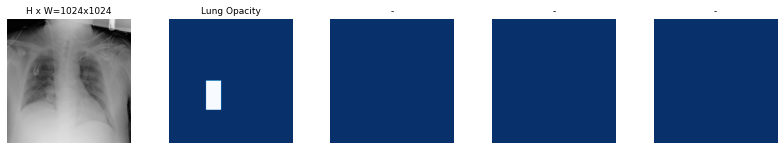

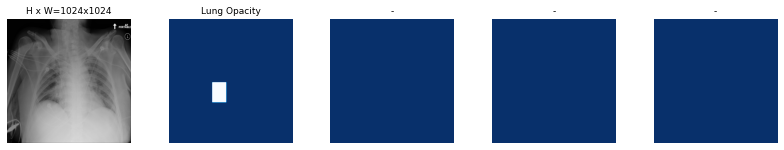

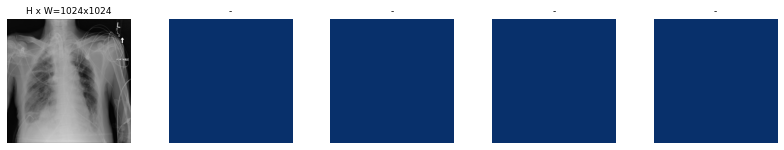

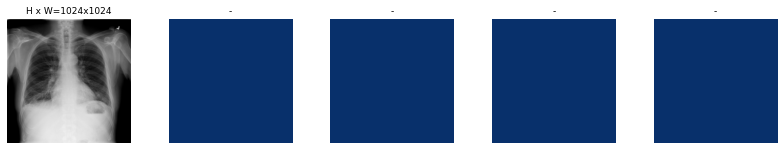

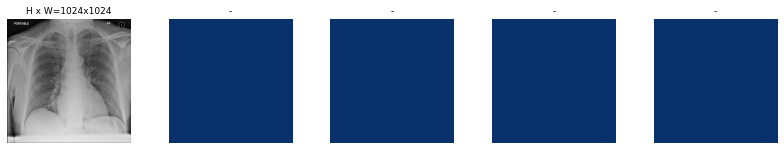

In [11]:
## Visualizing random 5 masks in train data
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [12]:
## Checking if tensorflow working on GPU
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.test.is_gpu_available()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0



True

## Mask RCNN Model

In [13]:
## Defining the configuration of our model. Parameters are changes to work on the given system
class DtConfig(Config):
    
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2 
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.88
    DETECTION_NMS_THRESHOLD = 0.08

    STEPS_PER_EPOCH = 300

config = DtConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.88
DETECTION_NMS_THRESHOLD        0.08
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [14]:
## Filter out warnings

import warnings 
warnings.filterwarnings("ignore")

In [15]:
## modelling

COCO_WT = "mask_rcnn_coco.h5"

model = modellib.MaskRCNN(mode='training', model_dir=model_directory,config=config)
model.load_weights(COCO_WT, by_name=True, exclude=["mrcnn_bbox_fc","mrcnn_class_logits","mrcnn_mask","mrcnn_bbox"])
#model.load_weights(COCO_WT, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead






In [16]:
## Augmenting the image so it becomes better and clear to feed in the model
augment_v1 = iaa.Sequential([
    iaa.OneOf([ 
        iaa.Affine(
            scale={"x": (0.98, 1.04), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-4, 4),
            shear=(-3, 3),
        ),
        iaa.PiecewiseAffine(scale=(0.0015, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

In [17]:
%%time
## Running the model with learning rate of 0.004 and limited layers
model.train(dataset_train, dataset_val, learning_rate=0.004, epochs=4, layers='heads') 

hist = model.keras_model.history.history


Starting at epoch 0. LR=0.004

Checkpoint Path: D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

In [18]:
%%time
## Running the model with learning rate of 0.0008 and all layers

model.train(dataset_train, dataset_val, learning_rate=0.0008, epochs=12, layers='all',augmentation=augment_v1) 

hist_new = model.keras_model.history.history
for a in hist_new: hist[a] = hist[a] + hist_new[a]


Starting at epoch 4. LR=0.0008

Checkpoint Path: D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [19]:
%%time
## Running the model with learning rate of 0.0004 and all layers

model.train(dataset_train, dataset_val, learning_rate=0.0004, epochs=20, layers='all',augmentation=augment_v1) 

hist_new = model.keras_model.history.history
for a in hist_new: hist[a] = hist[a] + hist_new[a]


Starting at epoch 12. LR=0.0004

Checkpoint Path: D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


In [20]:
%%time
## Running the model with learning rate of 0.0001 and all layers

model.train(dataset_train, dataset_val, learning_rate=0.0001, epochs=28, layers='all',augmentation=augment_v1) 

hist_new = model.keras_model.history.history
for a in hist_new: hist[a] = hist[a] + hist_new[a]


Starting at epoch 20. LR=0.0001

Checkpoint Path: D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


In [21]:
%%time
## Running the model with learning rate of 0.00005 and all layers

model.train(dataset_train, dataset_val, learning_rate=0.00005, epochs=35, layers='all',augmentation=augment_v1) 

hist_new = model.keras_model.history.history
for a in hist_new: hist[a] = hist[a] + hist_new[a]


Starting at epoch 28. LR=5e-05

Checkpoint Path: D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [22]:
## Get all epochs and best epoch

epch = range(1,len(next(iter(hist.values())))+1)
pd.DataFrame(hist, index=epch)



,val_loss,loss
1,1.648631,1.903878
2,1.581526,1.717389
3,1.635129,1.599177
4,1.476395,1.625846
5,1.361056,1.461841
6,1.377322,1.416635
7,1.374036,1.362197
8,1.353523,1.341897
9,1.212474,1.358818
10,1.374388,1.374356


In [23]:
## Best epoch - defined on lowest val Loss
best_epch = np.argmin(hist["val_loss"])
print("best epoch is : ", best_epch+1 ," wih val loss : ",hist["val_loss"][best_epch])

best epoch is :  32  wih val loss :  1.1330441951751709


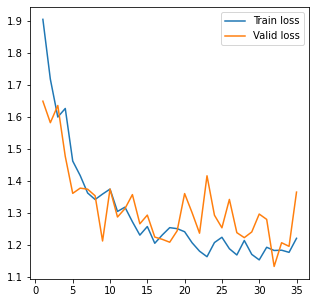

In [24]:
## Plotting a graph betweeen loss and val loss
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epch, hist["loss"], label="Train loss")
plt.plot(epch, hist["val_loss"], label="Valid loss")
plt.legend()

plt.show()

In [25]:
## Selecting the new model based on epcoch which gave lowest train loss and val loss (considering this instead of last weight to not overfit model) -
final_epoch = 31
print("best epoch is : ", final_epoch+1 ," With Val Loss : ",hist["val_loss"][final_epoch], " & Train Loss : ",hist["loss"][final_epoch])


cwd = os.getcwd()
path_m=cwd + "\model\pneumonia20200727T0710\mask_rcnn_pneumonia_0032.h5"

 
print(path_m)

best epoch is :  32  With Val Loss :  1.1330441951751709  & Train Loss :  1.1828463051716487
D:\greatlakes\CAPSTONE\model\pneumonia20200727T0710\mask_rcnn_pneumonia_0032.h5


## Prediction

In [26]:
## loading the inference model to predict
class InfConfig(DtConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inf = InfConfig()
model = modellib.MaskRCNN(mode='inference', config=inf, model_dir=model_directory)
model.load_weights(path_m, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 32


## Evaluation of the Model

In [27]:
## Creating the function to generate a dataframe

# Make predictions on test images, write out sample submission

## Will only predict bounding box if minimum score is .955

def predict_image(image_list, minimum_confidence=0.955):
    resize_factor = original_size / config.IMAGE_SHAPE[0]

    columns = ['patientId','PredictionString', 'PredictTarget']
    final_df = pd.DataFrame(columns=columns)
    counter=0

    for im, image_id in notebook.tqdm(enumerate(image_list)):
        ds = dcm.read_file(image_id)
        image = ds.pixel_array

        # Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)

        image, window, scale, padding, crop = utils.resize_image(
            image,
            min_dim=config.IMAGE_MIN_DIM,
            min_scale=config.IMAGE_MIN_SCALE,
            max_dim=config.IMAGE_MAX_DIM,
            mode=config.IMAGE_RESIZE_MODE)

        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        res_out = model.detect([image])
        result = res_out[0]

        output_string = ""
        assert( len(result['rois']) == len(result['class_ids']) == len(result['scores']) )

        if len(result['rois']) == 0:
            pass
        else:
            num_instances = len(result['rois'])

            for i in range(num_instances):
                if result['scores'][i] > minimum_confidence:
                    output_string += ' '
                    output_string += str(round(result['scores'][i], 2))
                    output_string += ' '

                    x1 = result['rois'][i][1]
                    y1 = result['rois'][i][0]
                    width = result['rois'][i][3] - x1
                    height = result['rois'][i][2] - y1
                    bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                       width*resize_factor, height*resize_factor)
                    output_string += bboxes_str

        output_string_len = len(output_string)
        target_out = 0
        if output_string_len>0:
            target_out = 1
        final_df.loc[im,'patientId'] = patient_id
        final_df.loc[im,'PredictionString'] = output_string
        final_df.loc[im,'PredictTarget'] = target_out

                
    return final_df

In [28]:
## Generating dataframe for test part of train data forr different min confidence values

#image_fps_test=image_fps_test[:200]
train_test_df_1 = predict_image(image_fps_test, minimum_confidence=0.950)
train_test_df_2 = predict_image(image_fps_test, minimum_confidence=0.955)
train_test_df_3 = predict_image(image_fps_test, minimum_confidence=0.960)
train_test_df_4 = predict_image(image_fps_test, minimum_confidence=0.965)
train_test_df_5 = predict_image(image_fps_test, minimum_confidence=0.970)
train_test_df_6 = predict_image(image_fps_test, minimum_confidence=0.975)
train_test_df_7 = predict_image(image_fps_test, minimum_confidence=0.980)
train_test_df_8 = predict_image(image_fps_test, minimum_confidence=0.985)
train_test_df_9 = predict_image(image_fps_test, minimum_confidence=0.990)


In [29]:
## Creating functions to get patient id list from path
def split_name(xyz):
    a, b = xyz.rsplit('\\', 1)
    x, y = b.split('.')

    return pd.Series({
        'patientId': x
    })

## Crrating function to define TF, TP, FP, FN

def TF_TP(row):
    if (row['Target'] == 1) & (row['PredictTarget'] == 1) :
        val = 'TP'
    elif (row['Target'] == 0) & (row['PredictTarget'] == 1) :
        val = 'FP'
    elif (row['Target'] == 1) & (row['PredictTarget'] == 0) :
        val = 'FN'
    else:
        val = 'TN'    
    return val

In [30]:
## Generating back original dataframe of train test images to compare
image_fps_test_df = pd.DataFrame(image_fps_test,columns=['Path'])
image_fps_test_df_new = image_fps_test_df['Path'].apply(split_name)
image_fps_test_df_fin = pd.concat([image_fps_test_df,image_fps_test_df_new],axis=1)

train_test_df_orig = pd.merge(image_fps_test_df_fin,train_class_dataframe,on='patientId', how='inner')
train_test_df_orig_fin = train_test_df_orig[['patientId','Target']]
train_test_df_orig_fin_2=train_test_df_orig_fin.drop_duplicates(subset='patientId', keep='first')

In [31]:
### create a final table joining the predictions and actual values to define True Positives, TN, FP , FN by generating a function

def predict_metrics(train_test_df,minimum_confidence ):
    Final_prediction_df_sem = pd.merge(train_test_df_orig_fin_2,train_test_df,on='patientId', how='inner')
    Final_prediction_df=Final_prediction_df_sem.drop_duplicates(subset='patientId', keep='first')
    Final_prediction_df['Condition'] = Final_prediction_df.apply(TF_TP, axis=1)
    
    ## First creating empty dataframe to store results
    columns_pred = ['Minimum_Confidence','True Positives','True Negatives', 'False Positives','False Negatives','Accuracy','Recall','Precision','F-Score','Specificity']
    Prediction_output = pd.DataFrame(columns=columns_pred)

    TP= len(Final_prediction_df[Final_prediction_df['Condition'] == 'TP'].index)
    TN= len(Final_prediction_df[Final_prediction_df['Condition'] == 'TN'].index)
    FP= len(Final_prediction_df[Final_prediction_df['Condition'] == 'FP'].index)
    FN= len(Final_prediction_df[Final_prediction_df['Condition'] == 'FN'].index)
    accu = (TP+TN)/(TP+TN+FP+FN)
    recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    F_Score = (2* recall*Precision)/(Precision+recall)
    Specificity = TN / (TN + FP)
    Prediction_output.loc[0,'Minimum_Confidence'] = minimum_confidence
    Prediction_output.loc[0,'True Positives'] = TP
    Prediction_output.loc[0,'True Negatives'] = TN
    Prediction_output.loc[0,'False Positives'] = FP
    Prediction_output.loc[0,'False Negatives'] = FN
    Prediction_output.loc[0,'Accuracy'] = round(accu,3)
    Prediction_output.loc[0,'Recall'] = round(recall,3)
    Prediction_output.loc[0,'Precision'] = round(Precision,3)
    Prediction_output.loc[0,'F-Score'] = round(F_Score,3)
    Prediction_output.loc[0,'Specificity'] = round(Specificity,3)
    return Prediction_output
    
    

In [32]:
## Getting final predictions at different confidence values to select best confidence value for the model

prediction_1 = predict_metrics(train_test_df_1, minimum_confidence=0.950)
prediction_2 = predict_metrics(train_test_df_2, minimum_confidence=0.955)
prediction_3 = predict_metrics(train_test_df_3, minimum_confidence=0.960)
prediction_4 = predict_metrics(train_test_df_4, minimum_confidence=0.965)
prediction_5 = predict_metrics(train_test_df_5, minimum_confidence=0.970)
prediction_6 = predict_metrics(train_test_df_6, minimum_confidence=0.975)
prediction_7 = predict_metrics(train_test_df_7, minimum_confidence=0.980)
prediction_8 = predict_metrics(train_test_df_8, minimum_confidence=0.985)
prediction_9 = predict_metrics(train_test_df_9, minimum_confidence=0.990)

prediction_final = pd.concat([prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9])
prediction_final

,Minimum_Confidence,True Positives,True Negatives,False Positives,False Negatives,Accuracy,Recall,Precision,F-Score,Specificity
0,0.95,1647,2012,2114,121,0.621,0.932,0.438,0.596,0.488
0,0.955,1600,2225,1901,168,0.649,0.905,0.457,0.607,0.539
0,0.96,1533,2495,1631,235,0.683,0.867,0.485,0.622,0.605
0,0.965,1440,2802,1324,328,0.72,0.814,0.521,0.635,0.679
0,0.97,1321,3106,1020,447,0.751,0.747,0.564,0.643,0.753
0,0.975,1127,3439,687,641,0.775,0.637,0.621,0.629,0.833
0,0.98,854,3749,377,914,0.781,0.483,0.694,0.57,0.909
0,0.985,445,4003,123,1323,0.755,0.252,0.783,0.381,0.97
0,0.99,90,4107,19,1678,0.712,0.051,0.826,0.096,0.995


#### Based on above - min confidence value of 0.97 is best as it has both high recall and high specificity -> implies false negatives are low as well as false positives arent very high. Now it is essential for the model to predict low number of FN because for FP an examination can take place again.


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



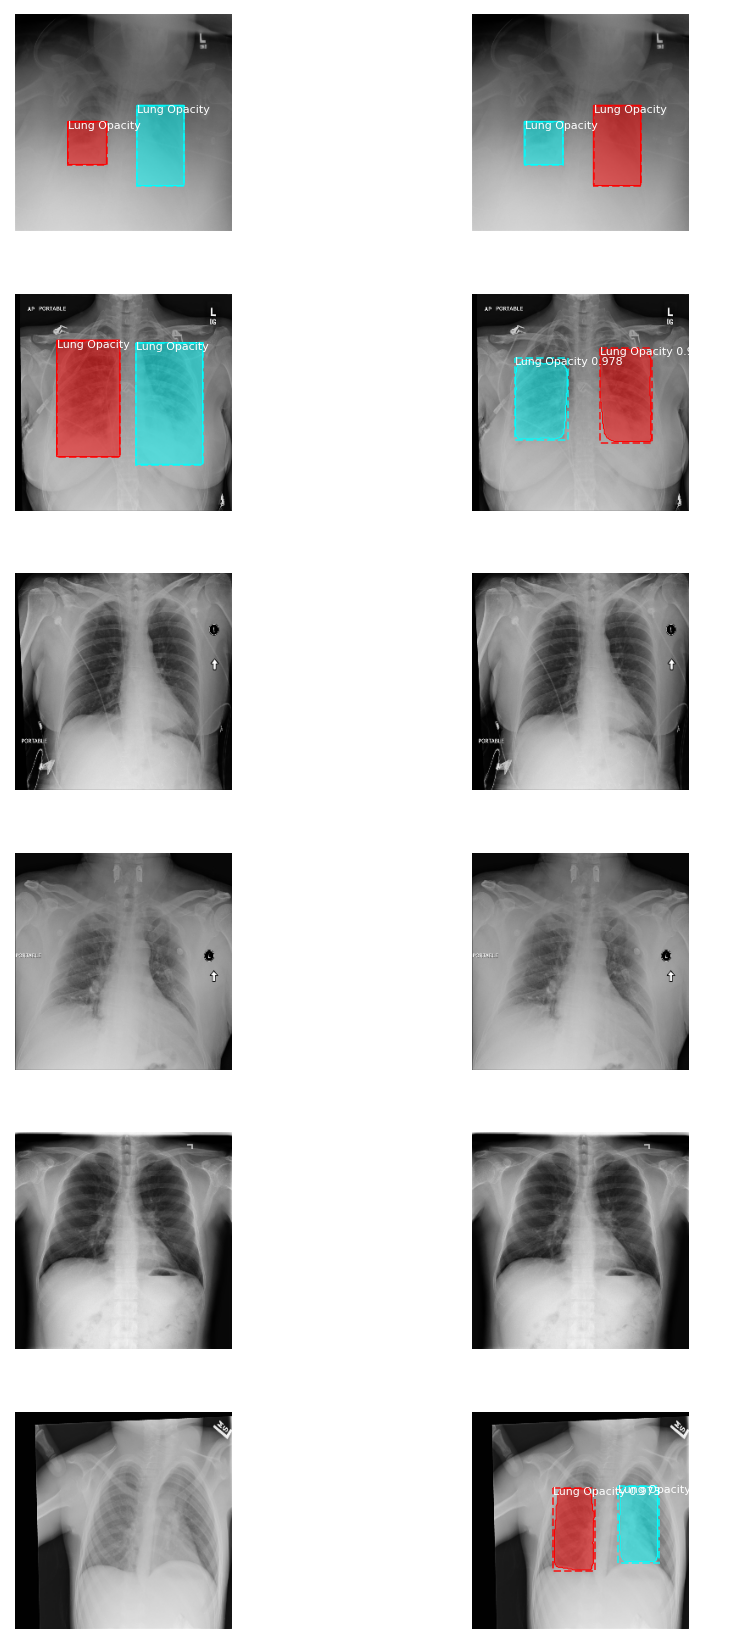

In [33]:
# randomly predicting 6 images with min confidence value of .97

minimum_confidence =.97

fig = plt.figure(figsize=(15, 30))

for x in range(6):

    imgid = random.choice(dataset_val.image_ids)
    
    orig, image_meta, classid, boundingbox, mask =modellib.load_image_gt(dataset_val, InfConfig, imgid, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*x + 1)
    visualize.display_instances(orig, boundingbox, mask, classid, dataset_val.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*x + 2)
    res = model.detect([orig])
    r = res[0]
    abc=0
    len_score= len(r['scores'])
    for i in range(len_score):
        abc=max(r['scores'][i],abc)
    #print(r['scores'],r['scores'].any() > minimum_confidence, len(r['scores']),abc, abc> minimum_confidence)
    if abc > minimum_confidence:
        visualize.display_instances(orig, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'],ax=fig.axes[-1])
    else:
        visualize.display_instances(orig, boundingbox, mask, classid, dataset_val.class_names, ax=fig.axes[-1])

## Generating Submission File

In [34]:
## Getting dcm folder path from json data
dcm_folder = train_class_dataframe['Path'].str.rsplit('\\',1).str[0]
dcm_folder=dcm_folder.drop_duplicates(keep='first')
dcm_folder_path=str(dcm_folder.iloc[0])
print(dcm_folder_path)

## Getting test data folder
test_folder_path = dcm_folder_path.replace("train","test")
print(test_folder_path)

## Creating test images list
test_fps = glob.glob(test_folder_path+'/'+'*.dcm')
test_folder_list = list(set(test_fps))

D:\greatlakes\CAPSTONE\input\rsna-pneumonia-detection-challenge\stage_2_train_images
D:\greatlakes\CAPSTONE\input\rsna-pneumonia-detection-challenge\stage_2_test_images


In [35]:
## Creating the file dataframe using above function
submission_fp = predict_image(test_folder_list, minimum_confidence=0.97)
submission_fp_fin = submission_fp[['patientId','PredictionString']]

## Export to CSV

submission_fp_fin.to_csv('Mask_RCNN_Submission_New.csv')